In [1]:
import math
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader,Dataset
from torch.hub import load_state_dict_from_url
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn.metrics import confusion_matrix, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Class for loading datasets
class CustomImageDataset(torch.utils.data.Dataset):
    
    # Initialize the dataset with image directory and transform
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.class_names)}
        self.images = []
        self.labels = []
        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.JPEG'):
                    self.images.append(os.path.join(class_dir, filename))
                    self.labels.append(self.class_to_idx[class_name])

    # This function returns the number of samples in the dataset.   
    def __len__(self):
        return len(self.images)
    
    # This function returns the image and the label index.
    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]
        image = torchvision.datasets.folder.default_loader(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [3]:
def dataloading(transform):
    # Load the dataset of images and apply the transformation
    dataset = CustomImageDataset(root_dir=r'/kaggle/input/image-classes-dataset/train_set/train_set/train_set')
    
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Set the random seed for reproducibility
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    
    # Splitting the dataset for validation and training in an 80:20 ratio     
    training_size = int(0.8 * len(dataset))
    validation_size = len(dataset) - training_size
    training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [training_size, validation_size])
    
    training_dataset.dataset.transform = transform
    validation_dataset.dataset.transform = valid_transform

    # Create a DataLoader for the training set and validation set
    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, num_workers=2, shuffle=True, generator=torch.Generator().manual_seed(0))
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, num_workers=2, shuffle=False)

    # Get the class names (labels) corresponding to the subfolders in the dataset
    class_names = dataset.class_names
    
    # Return the datasets and dataloaders for training and validation, along with the class names
    return training_dataset, validation_dataset, training_dataloader, validation_dataloader, class_names

In [4]:
# Define the image preprocessing steps
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the training and validation datasets, and create dataloaders for them
training_dataset, validation_dataset, training_dataloader, validation_dataloader, class_names = dataloading(train_transform)

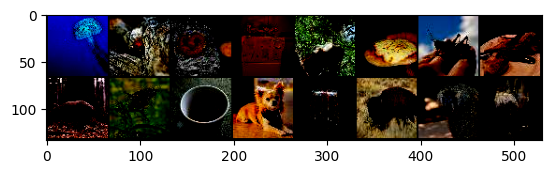

labels ['jellyfish', 'ladybug', 'pretzel', 'refrigerator', 'redpanda', 'pizza', 'grasshopper', 'pretzel', 'pig', 'butterfly', 'espresso', 'chihuahua', 'jellyfish', 'bison', 'baboon', 'pig']


In [5]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
     
data_iter = iter(training_dataloader)
images, labels = next(data_iter)

# show images and labels
timshow(torchvision.utils.make_grid(images))
print(f"labels {[class_names[labels[i]] for i in range(16)]}")

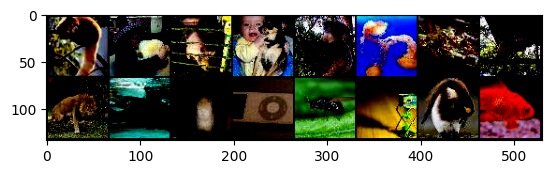

labels ['redpanda', 'sombrero', 'pig', 'chihuahua', 'koala', 'jellyfish', 'pizza', 'koala', 'lion', 'penguin', 'penguin', 'ipod', 'fly', 'hourglass', 'penguin', 'goldfish']


In [6]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
     
data_iter = iter(validation_dataloader)
images, labels = next(data_iter)

# show images and labels
timshow(torchvision.utils.make_grid(images))
print(f"labels {[class_names[labels[i]] for i in range(16)]}")

In [7]:
class MLP(nn.Module):
    
    # Constructor to initialize the MLP layers
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        
        # Defining three fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        # Adding ReLU activation function
        self.relu = nn.ReLU()  
    
    # Defining the forward pass of the model
    def forward(self, x):
        out = x.reshape(x.shape[0],-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
    
    # This function returns the optimizer function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)
    
    # This function returns the loss function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss() 

In [8]:
# prints an instance of the MLP class 
model = MLP(64 * 64 * 3, 1024, 512, 30)
print(model)

# prints number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

MLP(
  (fc1): Linear(in_features=12288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=30, bias=True)
  (relu): ReLU()
)
Total parameters: 13124126


In [9]:
class CNN(nn.Module):
    
    # Constructor to initialize the CNN layers
    def __init__(self,input_size, num_classes):
        super(CNN, self).__init__()
        
        # Defining the four Convolutional layer and Batch normalization layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Adding max pooling layer with kernel size 2x2         
        self.pool = nn.MaxPool2d(2)
        
        # Defining two fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(128 * input_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    # Defining the forward pass of the model
    def forward(self, x):
        out = self.pool(torch.relu(self.bn1(self.conv1(x))))
        out = self.pool(torch.relu(self.bn2(self.conv2(out))))
        out = self.pool(torch.relu(self.bn3(self.conv3(out))))
        out = torch.relu(self.bn4(self.conv4(out)))
        out = out.reshape(out.shape[0],-1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

    # This function returns the optimizer function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss()
    
    # This function returns the loss function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)

In [10]:
# prints an instance of the MLP class 
model = CNN(8 * 8, 30)
print(model)

# prints number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=30, bias=True)
)
Total parameters: 8518302


In [11]:
# For both validation and training data, this function will plot the graph for accuracy and loss.
# This function will read data from the csv file that we previously saved after running the model.

def plotgraph(filename, num_epochs):
    
    data = pd.read_csv(filename)
    x = np.arange(num_epochs)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    ax[0].plot(x, data['Training Accuracy'], label='Training')
    ax[0].plot(x, data['Validation Accuracy'], label='Validation')
    ax[0].set_title('Accuracy Graph')
    ax[0].set_xlabel('No. of epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(x, data['Training Loss'], label='Training')
    ax[1].plot(x, data['Validation Loss'], label='Validation')
    ax[1].set_title('Loss Graph')
    ax[1].set_xlabel('No. of epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.show()

In [12]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [13]:
# This training function will train the model with training dataset and 
# returns the training loss and accuracy after evaluation of the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    train_topk_accuracy = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_topk_accuracy += topk_accuracy(outputs, targets)[0].item()
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_topk_accuracy / len(train_loader)
    
    return train_loss, train_acc

# This training function will evaluate the model with training dataset and 
# returns the training loss and accuracy after validation of the model
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    valid_topk_accuracy = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            valid_topk_accuracy += topk_accuracy(outputs, targets)[0].item()
            
        val_loss = val_loss / len(val_loader)
        val_acc = valid_topk_accuracy / len(val_loader)
        
    return val_loss, val_acc

Epoch: 1/25 Train Loss: 3.1525, Train Accuracy: 12.73%, Validation Loss: 2.9419, Validation Accuracy: 18.16% 
Epoch: 2/25 Train Loss: 2.8277, Train Accuracy: 19.30%, Validation Loss: 2.7935, Validation Accuracy: 21.45% 
Epoch: 3/25 Train Loss: 2.6584, Train Accuracy: 24.22%, Validation Loss: 2.7182, Validation Accuracy: 22.83% 
Epoch: 4/25 Train Loss: 2.5133, Train Accuracy: 28.47%, Validation Loss: 2.6613, Validation Accuracy: 23.48% 
Epoch: 5/25 Train Loss: 2.3616, Train Accuracy: 33.19%, Validation Loss: 2.7117, Validation Accuracy: 23.25% 
Epoch: 6/25 Train Loss: 2.1973, Train Accuracy: 37.72%, Validation Loss: 2.6815, Validation Accuracy: 24.38% 
Epoch: 7/25 Train Loss: 2.0071, Train Accuracy: 44.01%, Validation Loss: 2.6647, Validation Accuracy: 25.27% 
Epoch: 8/25 Train Loss: 1.8012, Train Accuracy: 49.93%, Validation Loss: 2.7905, Validation Accuracy: 23.99% 
Epoch: 9/25 Train Loss: 1.5792, Train Accuracy: 56.99%, Validation Loss: 2.8776, Validation Accuracy: 23.61% 
Epoch: 10/

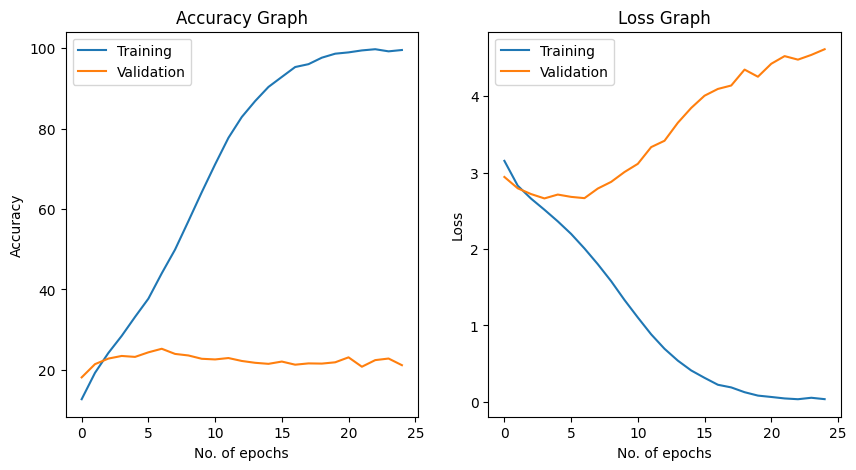

In [14]:
# This function will train and validate the model for specific number of epochs
def mlp_model_train(model, num_epochs, lr ,filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = model.loss_function()
    optimizer = model.optimizer_function(learning_rate = lr)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)

# Creating an instance of the MLP class 
mlp_model = MLP(input_size=64*64*3, hidden_size1=1024, hidden_size2=512, num_classes=30).to(device)

# Train the MLP model with 25 epochs and a learning rate of 0.001
mlp_model_train(mlp_model, num_epochs=25, lr=0.001, filename="mlp_basemodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename="mlp_basemodel.csv", num_epochs=25)

Epoch: 1/25 Train Loss: 2.7322, Train Accuracy: 22.24%, Validation Loss: 2.2677, Validation Accuracy: 33.88% 
Epoch: 2/25 Train Loss: 2.1038, Train Accuracy: 38.99%, Validation Loss: 2.1032, Validation Accuracy: 39.31% 
Epoch: 3/25 Train Loss: 1.7918, Train Accuracy: 47.39%, Validation Loss: 1.9428, Validation Accuracy: 44.22% 
Epoch: 4/25 Train Loss: 1.5151, Train Accuracy: 55.20%, Validation Loss: 2.1353, Validation Accuracy: 41.28% 
Epoch: 5/25 Train Loss: 1.2740, Train Accuracy: 61.84%, Validation Loss: 1.8927, Validation Accuracy: 46.81% 
Epoch: 6/25 Train Loss: 1.0332, Train Accuracy: 68.97%, Validation Loss: 1.8893, Validation Accuracy: 47.00% 
Epoch: 7/25 Train Loss: 0.7830, Train Accuracy: 77.47%, Validation Loss: 1.8596, Validation Accuracy: 48.39% 
Epoch: 8/25 Train Loss: 0.5576, Train Accuracy: 85.09%, Validation Loss: 2.0110, Validation Accuracy: 48.16% 
Epoch: 9/25 Train Loss: 0.3759, Train Accuracy: 90.78%, Validation Loss: 1.9617, Validation Accuracy: 49.38% 
Epoch: 10/

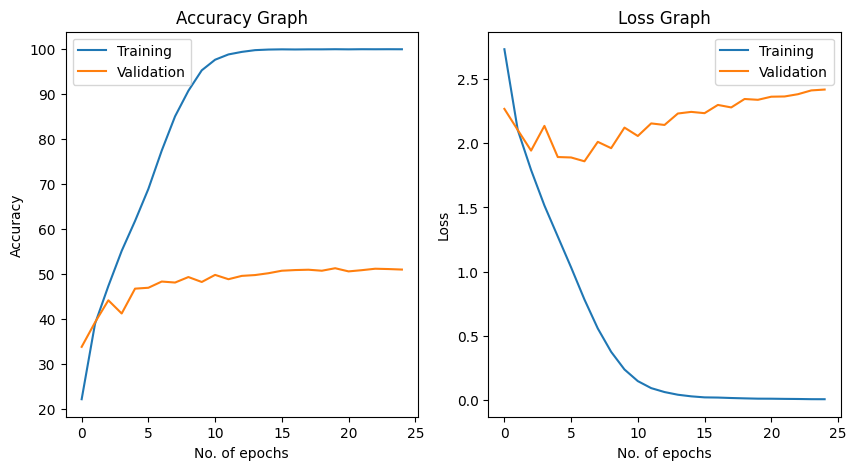

In [15]:
# This function will train and validate the model for specific number of epochs
def cnn_model_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = model.loss_function()
    optimizer = model.optimizer_function(learning_rate = lr)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)
    
# Creating an instance of the CNN class 
cnn_model = CNN(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 25 epochs and a learning rate of 0.001
cnn_model_train(cnn_model, num_epochs = 25, lr = 0.001, filename = "cnn_basemodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cnn_basemodel.csv", num_epochs = 25)

In [16]:
# This function will print the heat map of confusion matrix for validation and training dataset and ROC curve
def get_conf_rocc(model, train_loader, valid_loader, classes):
   
    model.to(device)

    # Get predictions and true labels for training set
    model.eval()
    train_preds = []
    train_true = []
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            train_preds += pred.cpu().numpy().tolist()
            train_true += target.cpu().numpy().tolist()

    # Get predictions and true labels for validation set
    valid_preds = []
    valid_true = []
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            valid_preds += pred.cpu().numpy().tolist()
            valid_true += target.cpu().numpy().tolist()

    # Calculate confusion matrices for training and validation sets
    train_cm = confusion_matrix(train_true, train_preds)
    valid_cm = confusion_matrix(valid_true, valid_preds)

    # Plotting the heat map of confusion matrix for training dataset
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(train_cm/train_cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap='Oranges', annot_kws={'fontsize': 8})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Training Set')
    plt.show()

    # Plotting the heat map of confusion matrix for validation dataset
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(valid_cm/valid_cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap='Oranges', annot_kws={'fontsize': 8})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

    # Plot ROC curves for top five classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    top_classes = sorted(range(len(classes)), key=lambda i: -valid_cm[i, i])[:5]
    for i in top_classes:
        class_preds = []
        class_true = []
        for j in range(len(valid_true)):
            if valid_true[j] == i:
                class_preds.append(valid_preds[j])
                class_true.append(1)
            else:
                class_preds.append(valid_preds[j])
                class_true.append(0)
        fpr[i], tpr[i], _ = roc_curve(class_true, class_preds)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    for i in top_classes:
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for {0} (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves for top 5 classes')
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, prop={'size': 8})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

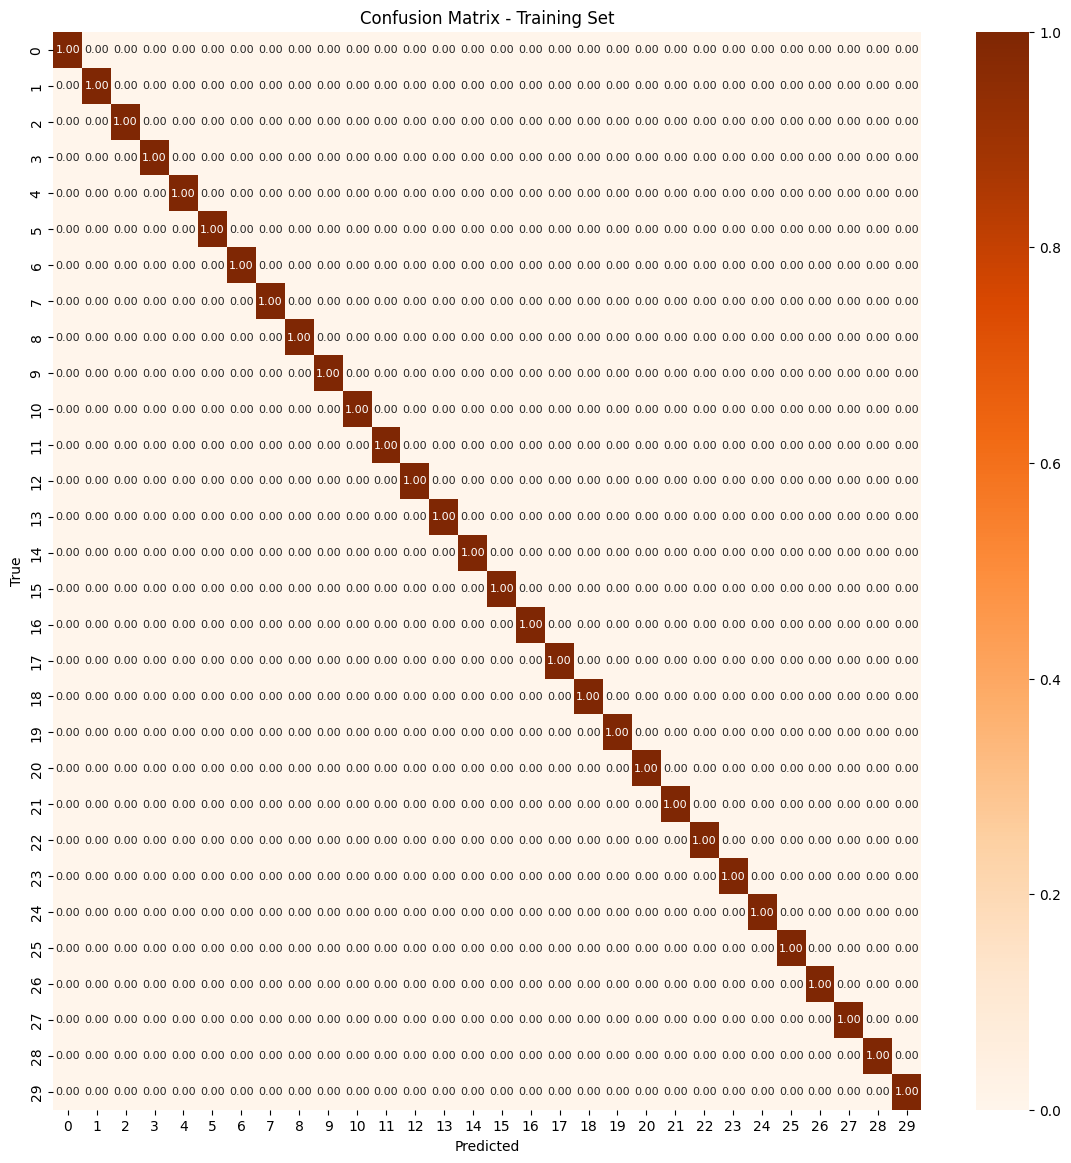

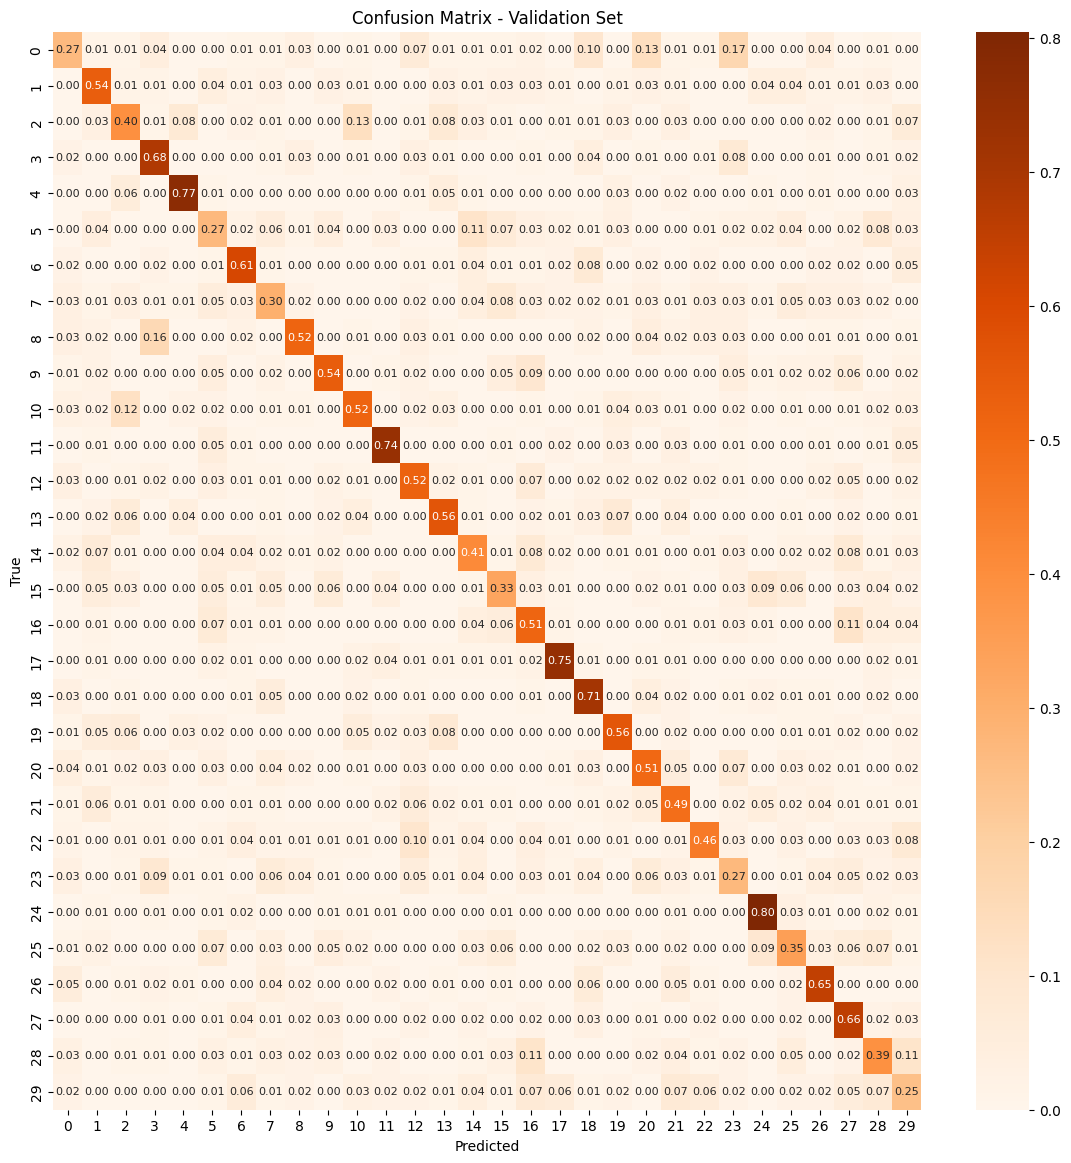

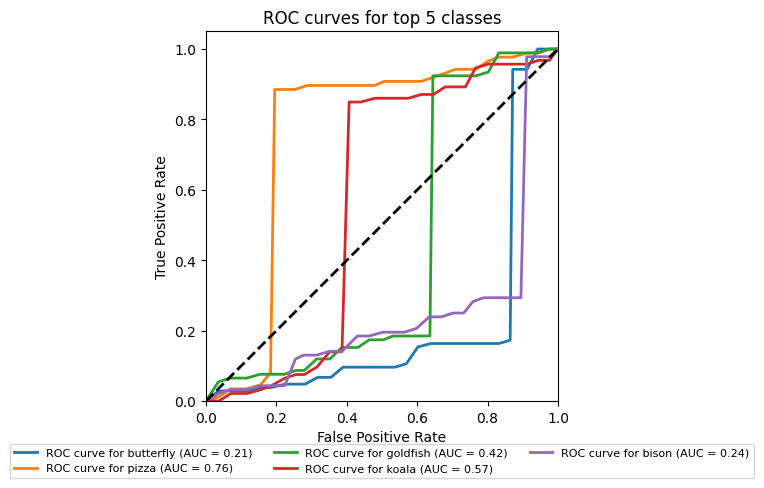

In [17]:
get_conf_rocc(cnn_model, training_dataloader, validation_dataloader, class_names)

In [18]:
#get_conf_rocc(cnn_dropmodel, training_dataloader, validation_dataloader, class_names)

In [19]:
# Defining the data augementation techniques for the dataset
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
    transforms.ColorJitter(hue=0.1, saturation=0.5, brightness=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(4),
    transforms.RandomAutocontrast(0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.GaussianBlur(3),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Load the training and validation datasets, and create dataloaders for them
training_dataset, validation_dataset, training_dataloader, validation_dataloader, class_names = dataloading(train_transform)

Epoch: 1/20 Train Loss: 2.7068, Train Accuracy: 23.36%, Validation Loss: 2.2757, Validation Accuracy: 33.79% 
Epoch: 2/20 Train Loss: 2.1034, Train Accuracy: 38.20%, Validation Loss: 2.0463, Validation Accuracy: 41.00% 
Epoch: 3/20 Train Loss: 1.7837, Train Accuracy: 47.69%, Validation Loss: 1.9537, Validation Accuracy: 42.90% 
Epoch: 4/20 Train Loss: 1.5442, Train Accuracy: 54.41%, Validation Loss: 1.9024, Validation Accuracy: 45.24% 
Epoch: 5/20 Train Loss: 1.2869, Train Accuracy: 62.09%, Validation Loss: 1.8719, Validation Accuracy: 47.47% 
Epoch: 6/20 Train Loss: 1.0461, Train Accuracy: 69.00%, Validation Loss: 1.9107, Validation Accuracy: 46.67% 
Epoch: 7/20 Train Loss: 0.8029, Train Accuracy: 76.62%, Validation Loss: 1.9395, Validation Accuracy: 46.88% 
Epoch: 8/20 Train Loss: 0.5806, Train Accuracy: 84.31%, Validation Loss: 2.0178, Validation Accuracy: 47.97% 
Epoch: 9/20 Train Loss: 0.3888, Train Accuracy: 90.69%, Validation Loss: 1.9956, Validation Accuracy: 48.41% 
Epoch: 10/

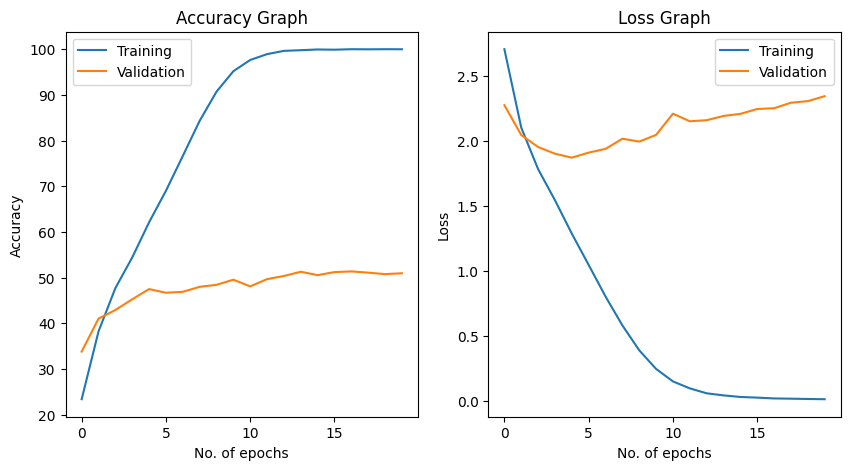

In [20]:
# Creating an instance of the CNN class 
cnn_augmentation_model = CNN(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.001
cnn_model_train(cnn_augmentation_model, num_epochs = 20, lr = 0.001, filename = "cnn_dataaugmentationmodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cnn_dataaugmentationmodel.csv", num_epochs = 20)

In [21]:
class CNN_DropOut(nn.Module):
    def __init__(self,input_size, num_classes, dropout_prob=0.5):
        super(CNN_DropOut, self).__init__()
        # Defining the four Convolutional layer and Batch normalization layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Adding max pooling layer with kernel size 2x2         
        self.pool = nn.MaxPool2d(2)
        
        # Defining two fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(128 * input_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        # Adding drop out function
        self.dropout = nn.Dropout(dropout_prob)

    # Defining the forward pass of the model
    def forward(self, x):
        out = self.pool(torch.relu(self.bn1(self.conv1(x))))
        out = self.pool(torch.relu(self.bn2(self.conv2(out))))
        out = self.dropout(out)
        out = self.pool(torch.relu(self.bn3(self.conv3(out))))
        out = self.dropout(out)
        out = torch.relu(self.bn4(self.conv4(out)))
        out = self.dropout(out)
        out = out.reshape(out.shape[0],-1)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

    # This function returns the optimizer function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss()
    
    # This function returns the loss function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)

Epoch: 1/30 Train Loss: 3.2212, Train Accuracy: 9.76%, Validation Loss: 2.9238, Validation Accuracy: 16.91% 
Epoch: 2/30 Train Loss: 2.8171, Train Accuracy: 18.97%, Validation Loss: 2.7331, Validation Accuracy: 21.60% 
Epoch: 3/30 Train Loss: 2.6331, Train Accuracy: 23.13%, Validation Loss: 2.5233, Validation Accuracy: 26.52% 
Epoch: 4/30 Train Loss: 2.5081, Train Accuracy: 26.57%, Validation Loss: 2.5175, Validation Accuracy: 27.43% 
Epoch: 5/30 Train Loss: 2.4147, Train Accuracy: 28.91%, Validation Loss: 2.4136, Validation Accuracy: 32.42% 
Epoch: 6/30 Train Loss: 2.3354, Train Accuracy: 31.69%, Validation Loss: 2.2883, Validation Accuracy: 33.05% 
Epoch: 7/30 Train Loss: 2.2767, Train Accuracy: 32.58%, Validation Loss: 2.2689, Validation Accuracy: 33.49% 
Epoch: 8/30 Train Loss: 2.2051, Train Accuracy: 35.35%, Validation Loss: 2.2502, Validation Accuracy: 35.26% 
Epoch: 9/30 Train Loss: 2.1663, Train Accuracy: 35.36%, Validation Loss: 2.2943, Validation Accuracy: 33.79% 
Epoch: 10/3

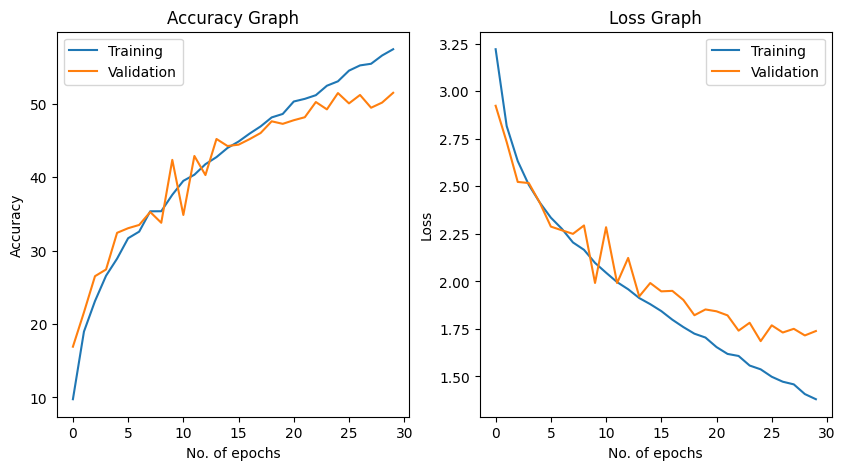

In [22]:
# This function will train and validate the model for specific number of epochs
def cnn_dropmodel_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = model.loss_function()
    optimizer = model.optimizer_function(learning_rate = lr)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)
    
# saving the starting time to calculate the excution time of the model
start_time = time.time()
    
# Creating an instance of the CNN class 
cnn_dropmodel = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.001
cnn_dropmodel_train(cnn_dropmodel, num_epochs = 30, lr = 0.001, filename = "cnn_dropmodel.csv")

# saving the end time to calculate the excution time of the model
end_time = time.time()

dropout_exectime = end_time - start_time

# save the model
torch.save(cnn_dropmodel.state_dict(), "/kaggle/working/cnn_dropmodel.pt")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cnn_dropmodel.csv", num_epochs = 30)

In [23]:
# Creating an instance of the CNN class 
cnn_model_lr1 = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.1
cnn_dropmodel_train(cnn_model_lr1, num_epochs = 30, lr = 0.1, filename = "cnn_lr1_model.csv")

Epoch: 1/30 Train Loss: 3.4415, Train Accuracy: 4.81%, Validation Loss: 3.3329, Validation Accuracy: 4.88% 
Epoch: 2/30 Train Loss: 3.3627, Train Accuracy: 5.21%, Validation Loss: 3.4732, Validation Accuracy: 3.51% 
Epoch: 3/30 Train Loss: 3.3678, Train Accuracy: 4.72%, Validation Loss: 3.2987, Validation Accuracy: 6.00% 
Epoch: 4/30 Train Loss: 3.3487, Train Accuracy: 4.79%, Validation Loss: 3.3080, Validation Accuracy: 4.86% 
Epoch: 5/30 Train Loss: 3.3555, Train Accuracy: 5.26%, Validation Loss: 3.3303, Validation Accuracy: 5.99% 
Epoch: 6/30 Train Loss: 3.3687, Train Accuracy: 5.00%, Validation Loss: 3.3266, Validation Accuracy: 4.27% 
Epoch: 7/30 Train Loss: 3.3598, Train Accuracy: 4.98%, Validation Loss: 3.3230, Validation Accuracy: 4.36% 
Epoch: 8/30 Train Loss: 3.3508, Train Accuracy: 5.19%, Validation Loss: 3.3154, Validation Accuracy: 5.25% 
Epoch: 9/30 Train Loss: 3.3411, Train Accuracy: 5.50%, Validation Loss: 3.3084, Validation Accuracy: 5.25% 
Epoch: 10/30 Train Loss: 3.3

In [24]:

# Creating an instance of the CNN class 
cnn_model_lr001 = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.001
cnn_dropmodel_train(cnn_model_lr001, num_epochs = 30, lr = 0.001, filename = "cnn_lr001_model.csv")

Epoch: 1/30 Train Loss: 3.2016, Train Accuracy: 10.28%, Validation Loss: 3.0513, Validation Accuracy: 13.15% 
Epoch: 2/30 Train Loss: 2.8161, Train Accuracy: 18.73%, Validation Loss: 2.6990, Validation Accuracy: 20.16% 
Epoch: 3/30 Train Loss: 2.6235, Train Accuracy: 23.47%, Validation Loss: 2.4911, Validation Accuracy: 28.01% 
Epoch: 4/30 Train Loss: 2.5089, Train Accuracy: 26.83%, Validation Loss: 2.4134, Validation Accuracy: 27.97% 
Epoch: 5/30 Train Loss: 2.4183, Train Accuracy: 29.11%, Validation Loss: 2.3310, Validation Accuracy: 31.58% 
Epoch: 6/30 Train Loss: 2.3534, Train Accuracy: 31.31%, Validation Loss: 2.2387, Validation Accuracy: 34.86% 
Epoch: 7/30 Train Loss: 2.2851, Train Accuracy: 33.53%, Validation Loss: 2.1598, Validation Accuracy: 37.71% 
Epoch: 8/30 Train Loss: 2.2293, Train Accuracy: 34.58%, Validation Loss: 2.2056, Validation Accuracy: 36.93% 
Epoch: 9/30 Train Loss: 2.1581, Train Accuracy: 36.54%, Validation Loss: 2.0908, Validation Accuracy: 40.66% 
Epoch: 10/

In [25]:
# Creating an instance of the CNN class 
cnn_model_lr0001 = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.0001
cnn_dropmodel_train(cnn_model_lr0001, num_epochs = 30, lr = 0.0001, filename = "cnn_lr0001_model.csv")

Epoch: 1/30 Train Loss: 3.4169, Train Accuracy: 4.15%, Validation Loss: 3.3696, Validation Accuracy: 7.73% 
Epoch: 2/30 Train Loss: 3.3570, Train Accuracy: 6.44%, Validation Loss: 3.3196, Validation Accuracy: 8.14% 
Epoch: 3/30 Train Loss: 3.2816, Train Accuracy: 8.97%, Validation Loss: 3.2654, Validation Accuracy: 9.62% 
Epoch: 4/30 Train Loss: 3.2065, Train Accuracy: 11.43%, Validation Loss: 3.1981, Validation Accuracy: 11.43% 
Epoch: 5/30 Train Loss: 3.1272, Train Accuracy: 13.05%, Validation Loss: 3.1424, Validation Accuracy: 13.17% 
Epoch: 6/30 Train Loss: 3.0515, Train Accuracy: 14.56%, Validation Loss: 3.0536, Validation Accuracy: 14.87% 
Epoch: 7/30 Train Loss: 2.9685, Train Accuracy: 16.52%, Validation Loss: 2.9522, Validation Accuracy: 18.58% 
Epoch: 8/30 Train Loss: 2.8969, Train Accuracy: 17.56%, Validation Loss: 2.8835, Validation Accuracy: 19.77% 
Epoch: 9/30 Train Loss: 2.8286, Train Accuracy: 19.66%, Validation Loss: 2.8342, Validation Accuracy: 21.51% 
Epoch: 10/30 Tra

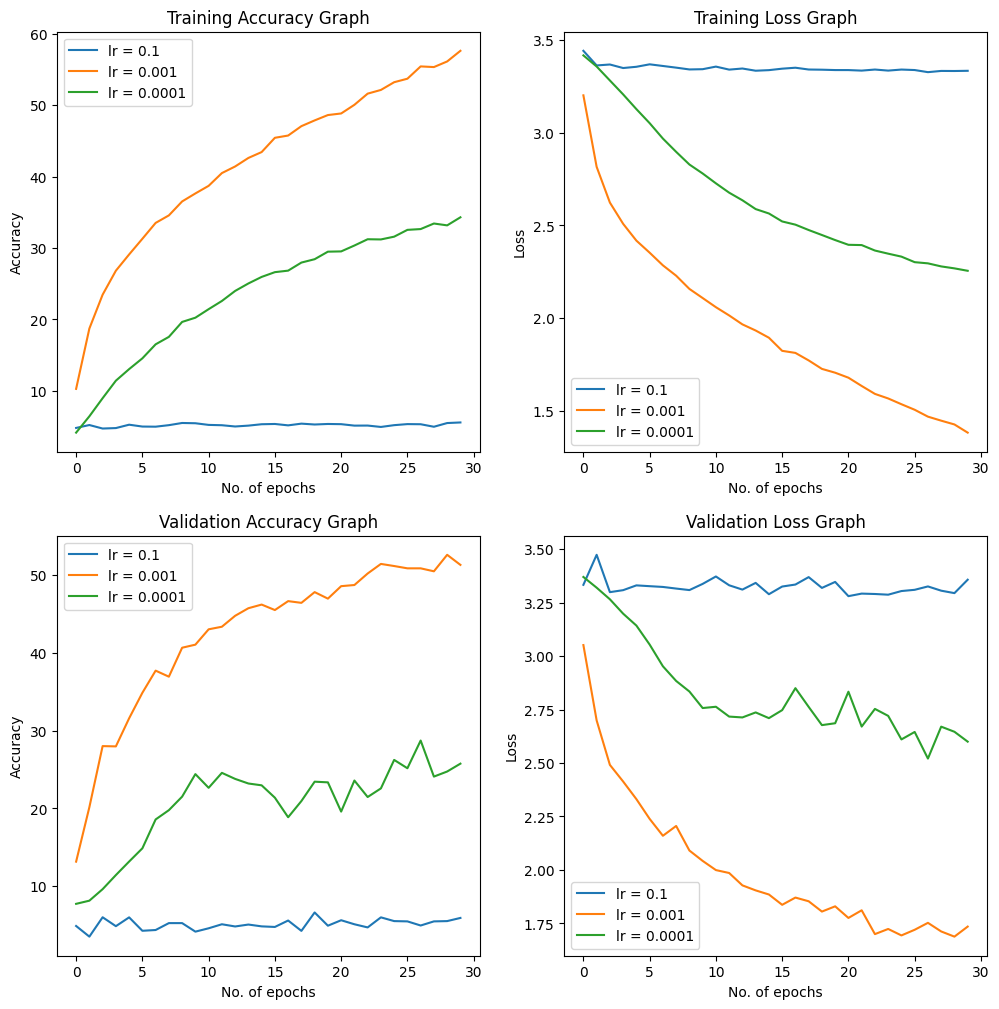

In [26]:
# Graphs for Hyper parameter tuning models
# For both validation and training data, this function will plot the graph for accuracy and loss.
# This function will read data from the csv file that we previously saved after running the model.

def plotgraph_learningrates(filename_1, filename_2, filename_3, num_epochs):
    
    data_1 = pd.read_csv(filename_1)
    data_2 = pd.read_csv(filename_2)
    data_3 = pd.read_csv(filename_3)
        
    x = np.arange(num_epochs)
    
    fig, ax = plt.subplots(2, 2, figsize=(12,12))

    ax[0, 0].plot(x, data_1['Training Accuracy'], label='lr = 0.1')
    ax[0, 0].plot(x, data_2['Training Accuracy'], label='lr = 0.001')
    ax[0, 0].plot(x, data_3['Training Accuracy'], label='lr = 0.0001')
    ax[0, 0].set_title('Training Accuracy Graph')
    ax[0, 0].set_xlabel('No. of epochs')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend()

    ax[0, 1].plot(x, data_1['Training Loss'], label='lr = 0.1')
    ax[0, 1].plot(x, data_2['Training Loss'], label='lr = 0.001')
    ax[0, 1].plot(x, data_3['Training Loss'], label='lr = 0.0001')
    ax[0, 1].set_title('Training Loss Graph')
    ax[0, 1].set_xlabel('No. of epochs')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].legend()
    
    ax[1, 0].plot(x, data_1['Validation Accuracy'], label='lr = 0.1')
    ax[1, 0].plot(x, data_2['Validation Accuracy'], label='lr = 0.001')
    ax[1, 0].plot(x, data_3['Validation Accuracy'], label='lr = 0.0001')
    ax[1, 0].set_title('Validation Accuracy Graph')
    ax[1, 0].set_xlabel('No. of epochs')
    ax[1, 0].set_ylabel('Accuracy')
    ax[1, 0].legend()
    
    ax[1, 1].plot(x, data_1['Validation Loss'], label='lr = 0.1')
    ax[1, 1].plot(x, data_2['Validation Loss'], label='lr = 0.001')
    ax[1, 1].plot(x, data_3['Validation Loss'], label='lr = 0.0001')
    ax[1, 1].set_title('Validation Loss Graph')
    ax[1, 1].set_xlabel('No. of epochs')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].legend()
    
    plt.show()


plotgraph_learningrates(filename_1 = "cnn_lr1_model.csv", filename_2 = "cnn_lr001_model.csv", 
                        filename_3 = "cnn_lr0001_model.csv", num_epochs = 30)

In [27]:
# Class for loading test datasets
class TestFolderData(torch.utils.data.Dataset):
    
    # Initialize the dataset with image directory
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.file_names = os.listdir(self.folder_path)
        
    # This function returns the number of samples in the dataset
    def __len__(self):
        return len(self.file_names)
    
    # This function returns the image and the image file name.
    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.file_names[idx])
        image =  torchvision.datasets.folder.default_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return self.file_names[idx],image

In [28]:

# This function will evaluate the test data and save the result in CSV file with image file name and predicted label
def generate_predictions(model, test_dataloader, output_file):
    model.eval()
    model.to(device)

    predictions = []
    file_names = []

    for batch, (file_name, images) in enumerate(test_dataloader):
        images = images.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.tolist())
        file_names.extend(file_name)

    # Create a dataframe with the file names and predictions, and save the results to a CSV file
    results_df = pd.DataFrame({'Id': file_names, 'Category': predictions})
    results_df.to_csv(output_file, index=False)

In [29]:
# Define the image preprocessing steps
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the dataset of images and apply the transformation
data_dir = '/kaggle/input/image-classes-dataset/test_set/test_set/test_set'
dataset = TestFolderData(data_dir , transform=transform)

# Create a DataLoader for the testing set
testdataloader = DataLoader(dataset, batch_size=12, shuffle=False, num_workers= 2)

# This function will evaluate the test data
generate_predictions(cnn_dropmodel, testdataloader, 'mm22mkm.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/test-data/test_set/test_set'

In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
     
data_iter = iter(testdataloader)
filename, images = next(data_iter)

# show images and labels
timshow(torchvision.utils.make_grid(images))
# print(f"labels {[filename[labels[i]] for i in range(16)]}")
print(filename)

In [ ]:
# Define the image preprocessing steps
cifar_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Download and load the CIFAR10 dataset
cifar_train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)

# Set the random seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Splitting the dataset for validation and training in an 80:20 ratio     
cifar_train_size = int(0.8 * len(cifar_train_data))
cifar_val_size = len(cifar_train_data) - cifar_train_size
cifar_train_data, cifar_val_data = torch.utils.data.random_split(cifar_train_data, [cifar_train_size, cifar_val_size])

# Create data loaders
batch_size = 64
cifar_train_loader = torch.utils.data.DataLoader(cifar_train_data, batch_size=batch_size, shuffle=True, num_workers= 2,
                                                 generator=torch.Generator().manual_seed(0))
cifar_val_loader = torch.utils.data.DataLoader(cifar_val_data, batch_size=batch_size, shuffle=False, num_workers= 2)

In [ ]:
#  Loading the pretrained alexnet model and the normal alexnet model
alexnet_pretrained = torchvision.models.alexnet(pretrained=True)
alexnet = torchvision.models.alexnet()

# Applying Finetuning to the normal alexnet model
alexnet.load_state_dict(alexnet_pretrained.state_dict())

# Modify the last layer for CIFAR-10 classification
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 10)

alexnet = alexnet.to(device)

# printing the summary of the number of parameters 
summary(alexnet, input_size=(3, 128, 128))

In [ ]:
# This function will train and validate cifar data  over the alex model for specific number of epochs 
def cifar_model_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr= lr, momentum = 0.9)
    
    train_loader = cifar_train_loader
    val_loader = cifar_val_loader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)

# Train the AlexNet model over the CIFAR-10 with 30 epochs and a learning rate of 0.001
cifar_model_train(alexnet, num_epochs = 30, lr = 0.001, filename = "cifar_results.csv")

In [ ]:
# Loading the alexnet model
alexnet_pretrained = torchvision.models.alexnet(pretrained=True)
frozen_model = torchvision.models.alexnet()

# Applying Finetuning to the normal alexnet model
frozen_model.load_state_dict(alexnet_pretrained.state_dict())

# The frozen_model will have AlexNet model with freezing layers
for param in frozen_model.features.parameters():
    param.requires_grad = False

# Modify the last layer for CIFAR-10 classification
num_ftrs = frozen_model.classifier[6].in_features
frozen_model.classifier[6] = nn.Linear(num_ftrs, 10)
    
frozen_model = frozen_model.to(device)

# Train the AlexNet model over the CIFAR-10 with 15 epochs and a learning rate of 0.001
cifar_model_train(frozen_model, num_epochs = 30, lr = 0.001, filename = "cifar_frozen_model_results.csv")

In [ ]:
# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cifar_results.csv", num_epochs = 30)

In [ ]:
# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cifar_frozen_model_results.csv", num_epochs = 30)

In [ ]:
# This function will train and validate TinyImageNet30 dataset over the alex model for specific number of epochs 
def alex_tiny_model(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)

In [ ]:
# saving the starting time to calculate the excution time of the model
start_time = time.time()

# Loading the pretrained alexnet model and the normal alexnet model
alexnet_pretrained = torchvision.models.alexnet(pretrained=True)
alexnet_tiny = torchvision.models.alexnet()

# Applying Finetuning to the normal alexnet model
alexnet_tiny.load_state_dict(alexnet_pretrained.state_dict())

# Modify the last layer for TinyImageNet30 classification
num_ftrs = alexnet_tiny.classifier[6].in_features
alexnet_tiny.classifier[6] = nn.Linear(num_ftrs, 30)

alexnet_tiny = alexnet_tiny.to(device)

# Train the AlexNet model over the TinyImageNet30 with 30 epochs and a learning rate of 0.001
alex_tiny_model(alexnet_tiny, num_epochs = 30, lr = 0.0001, filename = "alex_tiny_results.csv")

# saving the end time to calculate the excution time of the model
end_time = time.time()

alexexecution_time = end_time - start_time

# save the model
torch.save(alexnet_tiny.state_dict(), "/kaggle/working/alexnet.pt")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "alex_tiny_results.csv", num_epochs = 30)

In [ ]:
# Graphs for mymodel and alexnet model
# For both validation and training data, this function will plot the graph for accuracy and loss.
# This function will read data from the csv file that we previously saved after running the model.

def plotgraph_model(filename_1, filename_2, num_epochs):
    
    data_1 = pd.read_csv(filename_1)
    data_2 = pd.read_csv(filename_2)
   
    x = np.arange(num_epochs)
    
    fig, ax = plt.subplots(2, 2, figsize=(12,12))

    ax[0, 0].plot(x, data_1['Training Accuracy'], label='AlexNet')
    ax[0, 0].plot(x, data_2['Training Accuracy'], label='mymodel')
    ax[0, 0].set_title('Training Accuracy Graph')
    ax[0, 0].set_xlabel('No. of epochs')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend()

    ax[0, 1].plot(x, data_1['Training Loss'], label='AlexNet')
    ax[0, 1].plot(x, data_2['Training Loss'], label='mymodel')
    ax[0, 1].set_title('Training Loss Graph')
    ax[0, 1].set_xlabel('No. of epochs')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].legend()
    
    ax[1, 0].plot(x, data_1['Validation Accuracy'], label='AlexNet')
    ax[1, 0].plot(x, data_2['Validation Accuracy'], label='mymodel')
    ax[1, 0].set_title('Validation Accuracy Graph')
    ax[1, 0].set_xlabel('No. of epochs')
    ax[1, 0].set_ylabel('Accuracy')
    ax[1, 0].legend()
    
    ax[1, 1].plot(x, data_1['Validation Loss'], label='AlexNet')
    ax[1, 1].plot(x, data_2['Validation Loss'], label='mymodel')
    ax[1, 1].set_title('Validation Loss Graph')
    ax[1, 1].set_xlabel('No. of epochs')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].legend()
    
    plt.show()


plotgraph_model(filename_1 = "alex_tiny_results.csv", filename_2 = "cnn_dropmodel.csv" , num_epochs = 30)

In [ ]:
# This function will print the heat map of confusion matrix for validation and training dataset and ROC curve
def get_conf(model, valid_loader, classes):
   
    model.to(device)

   # Get predictions and true labels for validation set
    valid_preds = []
    valid_true = []
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            valid_preds += pred.cpu().numpy().tolist()
            valid_true += target.cpu().numpy().tolist()

    valid_cm = confusion_matrix(valid_true, valid_preds)

    # Plotting the heat map of confusion matrix for validation dataset
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(valid_cm/valid_cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap='Oranges', annot_kws={'fontsize': 8})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
get_conf(alexnet_tiny, validation_dataloader, class_names)

In [ ]:
get_conf(cnn_dropmodel, validation_dataloader, class_names)

In [ ]:
# table contain excution time information , time per sample , CPU/GPU for alexnet and my model
data = [["My Model", "GPU T4 x2", round(dropout_exectime, 2)],
        ["AlexNet", "GPU T4 x2", round(alexexecution_time, 2)]]

fig, ax = plt.subplots()
table_data = ax.table(cellText=data, colLabels=["Model", "CPU or GPU", "Execution Time(sec)"],
                      cellLoc='center', cellColours=[['#e6f2ff']*3]*2, bbox=[0.5, 0, 1.2, 1])


table_data.auto_set_font_size(False)
table_data.set_fontsize(12)

for i in range(len(data)):
    for j in range(len(data[0])):
        cell = table_data.get_celld()[i, j]
        cell.set_text_props(fontfamily='serif', fontsize=12)

ax.set_axis_off()
table_data.auto_set_column_width(col=list(range(len(data[0]))))

plt.show()

In [ ]:
!pip install torchcam

In [ ]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2

In [ ]:
image_paths = ['86e47fac_9c14.JPEG', '38c7e3a4_3df9.JPEG', 'd02a4e07_8f8a.JPEG', '69058482_40d2.JPEG']

transform = transforms.Compose([
    transforms.ToTensor(),
])

images = []
for image_path in image_paths:
    img = Image.open('/kaggle/input/test-data/test_set/test_set/' + image_path)
    img = transform(img)
    images.append(img)

model = CNN_DropOut(input_size=8*8, num_classes=30)
model.to(device)
weights = torch.load('cnn_dropmodel.pt')
model.load_state_dict(weights)
model.eval()

last_conv_layer_name = [name for name, module in model.named_modules() if isinstance(module, nn.Conv2d)][-1]
cam_extractor = SmoothGradCAMpp(model=model, input_shape=(3, 64, 64), target_layer=last_conv_layer_name)

for i in range(len(image_paths)):
    image = images[i].to(device)
    out = model(image.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    result = overlay_mask(to_pil_image(image), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)  
    plt.imshow(result)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
image_paths = ['1ec20470_d3df.JPEG', '04f853fc_2ae3.JPEG', '0688cbd3_6fbf.JPEG', '6e208a7a_25e9.JPEG']

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])

images = []
for image_path in image_paths:
    img = Image.open('/kaggle/input/test-data/test_set/test_set/' + image_path)
    img = transform(img)
    images.append(img)

alexnet = torchvision.models.alexnet()
features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(features, 30)
alexnet.to(device)
weights = torch.load('alexnet.pt')
alexnet.load_state_dict(weights)
alexnet.eval()

cam_extractor = SmoothGradCAMpp(model=alexnet, input_shape=(3, 224, 224))

for i in range(len(image_paths)):
    image = images[i].to(device)
    out = alexnet(image.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    result = overlay_mask(to_pil_image(image), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    plt.imshow(result)
    plt.axis('off')
    plt.tight_layout()
    plt.show()